In [56]:
import cv2 as cv
import numpy as np
from skimage.io import imshow
from matplotlib import pyplot as plt

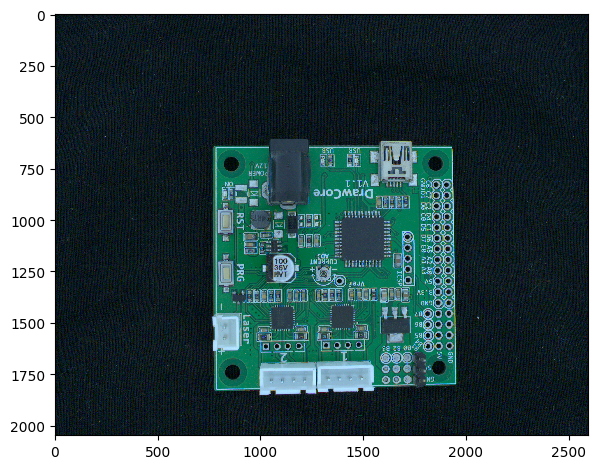

In [5]:
im = cv.cvtColor(
    cv.imread("support/examples/34_drawcore_uc_16mm_f8_6448_original.bmp"),
    cv.COLOR_BGR2RGB,
)
imshow(im)

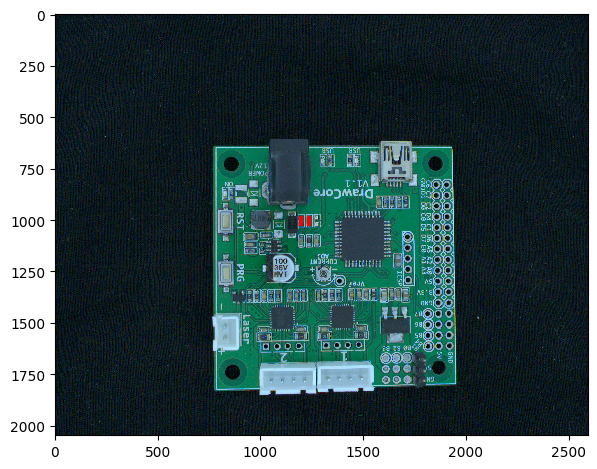

In [34]:
mask_color = [255, 0, 0]  # RGB
im_mask = cv.cvtColor(
    cv.imread("support/examples/34_drawcore_uc_16mm_f8_6448_mask.bmp"), cv.COLOR_BGR2RGB
)
imshow(im_mask)

# Remove background (black textile)


## Threshold


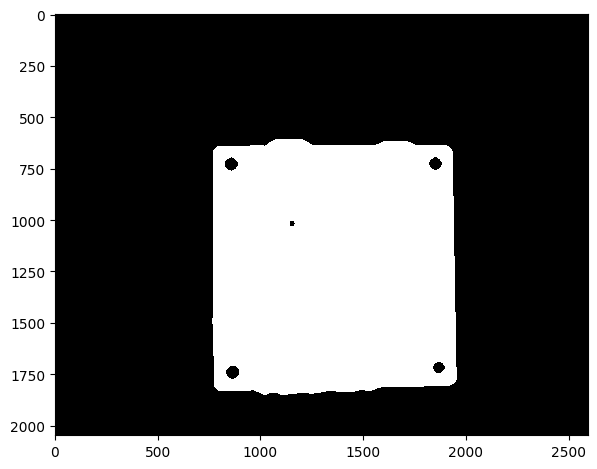

In [6]:
im1 = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

# Blur to vanish texture defects
im1 = cv.medianBlur(im1, 55)

# Arbitrary selected global threshold to separate background
val, im1 = cv.threshold(im1, 40, 255, cv.THRESH_BINARY)
imshow(im1, cmap="gray")

## Select connected components


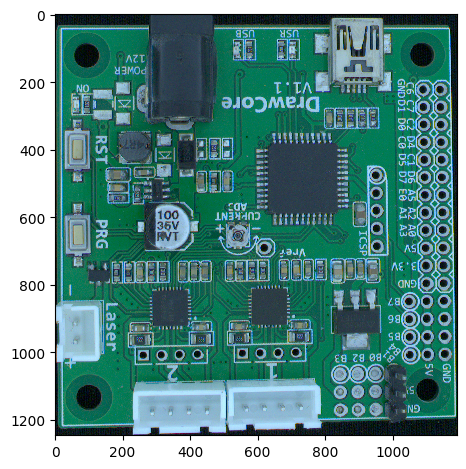

In [30]:
def cut(im, value):
    t = value[cv.CC_STAT_TOP]
    l = value[cv.CC_STAT_LEFT]

    w = value[cv.CC_STAT_WIDTH]
    h = value[cv.CC_STAT_HEIGHT]

    return im[t : t + h, l : l + w]


analysis = cv.connectedComponentsWithStats(im1, cv.CV_32S)
(_, _, values, _) = analysis

# Select the biggest connected component (PCB desk)
mx, mxi = 0, 0
for i, value in enumerate(values):
    area = value[cv.CC_STAT_AREA]
    if area >= mx:
        mxi = i

value = values[mxi]
im2 = cut(im, value)
im2_masked = cut(im_mask, value)

imshow(im2)

# Component detection

## Histogram back projection

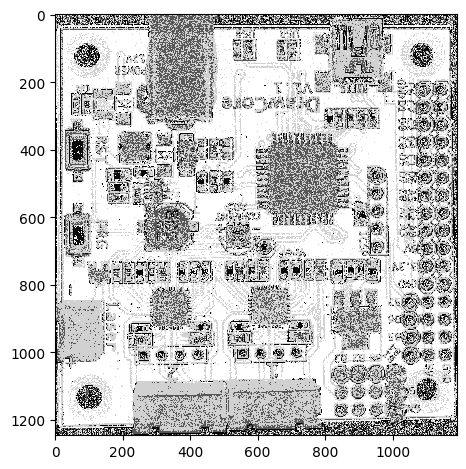

In [8]:
def back_projection(im, bins):
    # Calculate histogram over cropped image to minimize influence of
    # possible global background remainder (black textile)
    off_x = int(0.1 * im.shape[0])
    off_y = int(0.1 * im.shape[1])
    tmp = im[off_x:-off_x, off_y:-off_y]

    hist_size = max(bins, 2)
    ranges = [0, 180]

    hist = cv.calcHist([tmp], [0], None, [hist_size], ranges, accumulate=False)
    cv.normalize(hist, hist, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

    return cv.calcBackProject([im], [0], hist, ranges, scale=1)

im3 = im2

hsv = cv.cvtColor(im3, cv.COLOR_BGR2HSV)
im3 = np.empty(hsv.shape, hsv.dtype)
cv.mixChannels([hsv], [im3], (0, 0))

# Change bin size to achieve better results
imshow(back_projection(im3, 10))

## Weighted back projection

The bigger the bins size, the less details we are able to catch. Do average of different bin sizes while applying higher heights for smaller bins


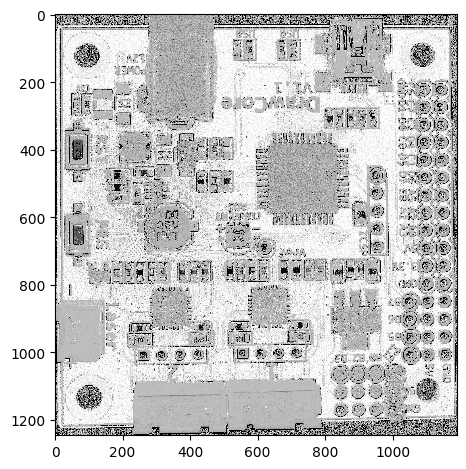

In [26]:
lb = 5
ub = 45

im3 = im2

hsv = cv.cvtColor(im3, cv.COLOR_BGR2HSV)
im3 = np.empty(hsv.shape, hsv.dtype)
cv.mixChannels([hsv], [im3], (0, 0))


# Weight is just inversion of bin size
im4 = back_projection(im3, lb).astype(float)
for i, bins in enumerate(range(lb + 1, ub)):
    im4 += (1 / bins) * back_projection(im3, bins)

im4 = (im4 / im4.max() * 255).astype(np.uint8)

imshow(im4, cmap="grey")

In [27]:
# cv.imwrite('test.bmp', im4)

True

# Missing component detection
Missing component detection is based on image profiling (sum of pixels along axis). Missing component allow the PCB background to be detected, which will cause high peak on image chunk profile.

In [41]:
def cut(im, value):
    t = value[cv.CC_STAT_TOP]
    l = value[cv.CC_STAT_LEFT]

    w = value[cv.CC_STAT_WIDTH]
    h = value[cv.CC_STAT_HEIGHT]

    return im[t : t + h, l : l + w]


def extract(im: np.ndarray, color: list[int], masked: np.ndarray):
    mask = cv.inRange(masked, color, color)
    analysis = cv.connectedComponentsWithStats(mask, cv.CV_32S)
    (_, _, values, _) = analysis

    chunks = []
    im = np.multiply(im, mask)
    for i in range(1, len(values)):
        chunks.append(255 - cut(im, values[i]))
    return chunks

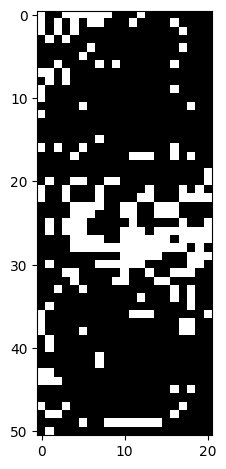

In [77]:
chunks = extract(im4, np.array(mask_color), im2_masked)

# Apply threshold (think of this threshold as of confidence level: how confident we need to be about each pixel belonging to background class)
chunks = [c > (255 * 0.8) for c in chunks]
imshow(chunks[0])

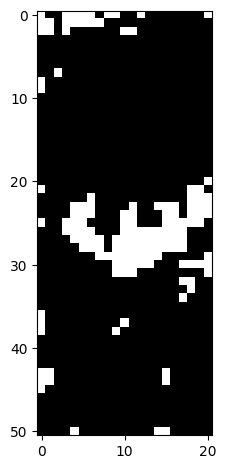

In [95]:
missing = chunks[0]
present = chunks[1]


def remove_noise(c):
    c = c.astype(np.uint8)
    c = cv.medianBlur(c, 3)
    return c.astype(bool)


present = remove_noise(present)
missing = remove_noise(missing)

delta = np.logical_xor(present, missing)
imshow(delta)

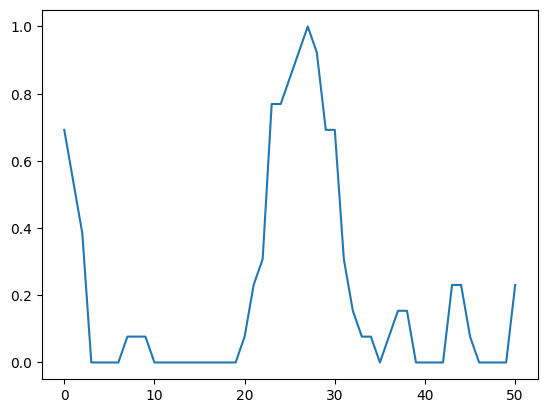

In [98]:
plt.close("all")
fig, ax = plt.subplots()

y = np.apply_along_axis(np.sum, 1, delta)
y = y / y.max()

ax.plot(y)